# Image Augmentation for Object Detection
We need a lot of annotated images to train Computer Vision models.<br>
Collecting these images might be easy but labelling them costs a lot of time.<br>
That's why we usually want to minimize this effort and try to get the maximum out of our already available data.<br>

In the context of simple image classification where we have one label per image it can be done easily via image augmentation.<br>
You can crop, rotate, shear, etc. your image as you like it - the label stays the same.<br>
However, if you're trying to train an object detection model, this doesn't work anymore because your labels (coordinates) will change if you transform the image.<br>
To overcome this challenge we will not only transform our image but also the corresponding labels.<br>

The class I've developed receives a path to your image folder as well as configurations for your augmentations.<br>
Currently implemented augmentations are:<br>
* Horizontal Flipping
* HSV Transformations
* Mosaic Stitching

It is possible to implement other augmentation functions as well but I found these to be the most useful ones.<br>

In the last step I load my transformed images into SAS Viya and display them.<br>
They're now ready to be used as training images for a deep learning model.<br>

### Imports

In [1]:
from glob import glob
import os
import random
from random import randint
import numpy as np 
import cv2
import csv
from matplotlib import pyplot as plt
import itertools
import copy

In [2]:
class AugmentObjectDetectionData():
    def __init__(self, load_path = '', save_path='', max_height=416, max_width=416):
        self.load_path = load_path
        self.save_path = save_path
        self.image_paths = self.get_imagepaths(load_path)
        self.max_dimensions = (max_width, max_height, 3)
        return
    
    def get_imagepaths(self, load_path):
        image_paths = glob(load_path+'*.jpg')
        image_paths = image_paths + glob(load_path+'*.png')
        return image_paths
    
    def set_configuration(self, configuration=dict()):
        # configure the augmentation task
        self.mutations = configuration['mutations'] if 'mutations' in configuration else ['horizontal_flip']
        self.number_augmentations = configuration['number_augmentations'] if 'number_augmentations' in configuration else 1
        self.coord_type = configuration['coord_type'] if 'coord_type' in configuration else 'yolo'
        self.h_flip_probability = configuration['h_flip_probability'] if 'h_flip_probability' in configuration else 0.5
        self.mosaic_probability = configuration['mosaic_probability'] if 'mosaic_probability' in configuration else 0.2
        self.hsv_probability = configuration['hsv_probability'] if 'hsv_probability' in configuration else 0.5
        self.hsv_hue = configuration['hsv_hue'] if 'hsv_hue' in configuration else list(range(-20,20))
        self.hsv_saturation = configuration['hsv_saturation'] if 'hsv_saturation' in configuration else list(range(-20,20))
        self.hsv_brightness = configuration['hsv_brightness'] if 'hsv_brightness' in configuration else list(range(-20,20))
        self.save_augmentations = configuration['save_augmentations'] if 'save_augmentations' in configuration else False
        self.save_img_format = configuration['save_img_format'] if 'save_img_format' in configuration else 'jpg'
        
    def read_img_objs_bbox(self, img_path):
        # read images and corresponding label files
        # currently only yolo is supported ...
        img = cv2.imread(img_path)
        path = '{}.txt'.format(img_path.split('.')[0])
        with open(path) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            objs = []
            bboxes = []
            for row in csv_reader:
                obj = row[0]
                bbox = np.array([row[1], row[2], row[3], row[4]], dtype=np.float)
                if self.coord_type == 'yolo':
                    bbox = self.yolo_to_rect(bbox, img.shape)
                objs.append(obj)
                bboxes.append(bbox)
            objs = np.array(objs, dtype=str)
            bboxes = np.array(bboxes, dtype=np.float)
        path = path.split('/')[-1].split('.')[0]
        return img, objs, bboxes, path
    
    def yolo_to_rect(self, bbox, img_shape):
        # transform yolo coordinates to rectangle format
        x1 = bbox[0]*img_shape[1]-bbox[2]*img_shape[1]/2
        y1 = bbox[1]*img_shape[0]-bbox[3]*img_shape[0]/2
        x2 = bbox[0]*img_shape[1]+bbox[2]*img_shape[1]/2
        y2 = bbox[1]*img_shape[0]+bbox[3]*img_shape[0]/2
        rect_bbox = np.array([x1,y1,x2,y2], dtype=np.float)
        return rect_bbox

    def rect_to_yolo(self, bbox, img_shape):
        # transform rectangle coordinates to yolo format
        w = (bbox[2]-bbox[0])/img_shape[1]
        h = (bbox[3]-bbox[1])/img_shape[0]
        x = bbox[0]/img_shape[1]+w/2
        y = bbox[1]/img_shape[0]+h/2
        yolo_bbox = np.array([x,y,w,h], dtype=np.float)
        return yolo_bbox
    
    def draw_boxes(self, img, objs, bboxes, color=None):
        # helper function to draw boxes (mostly used for debugging)
        bboxes = bboxes.astype(np.int16)
        if color == None:
            color = (255,255,255)
        for box in bboxes:
            #box_rect = self.yolo_to_rect(box, img_shape)
            #box_rect = np.array(box_rect, dtype=int)
            #pt1, pt2 = (box_rect[0], box_rect[1]), (box_rect[2], box_rect[3])
            pt1, pt2 = (box[0], box[1]), (box[2], box[3])
            annotated_img = cv2.rectangle(img, pt1, pt2, color=color, thickness=3)
        return annotated_img
    
    def save(self, img, objs, bboxes, path):
        # resizes the image and bounding boxes if necessary and finally saves them into the save-folder
        bboxes = bboxes.astype(np.int16)
        label_string = ''
        path = self.save_path + path
        if img.shape != self.max_dimensions:
            bboxes = self.resize_bboxes(img.shape, self.max_dimensions, bboxes, [0,0])
            img = cv2.resize(img, (self.max_dimensions[0], self.max_dimensions[1]))
        for i in range(len(objs)):
            bbox = self.rect_to_yolo(bboxes[i],img.shape)
            label_string = label_string + '{},{},{},{},{}\n'.format(objs[i],bbox[0],bbox[1],bbox[2],bbox[3])
        with open("{}.txt".format(path), "w") as text_file:
            print(label_string, file=text_file)
        cv2.imwrite("{}.{}".format(path, self.save_img_format),img)
        
    def mosaic(self, img, objs, bboxes):
        # create a mosaic of the current image + 3 randomly sampled images
        if random.random() < self.mosaic_probability:
            mosaic_image_paths = random.sample(self.image_paths, 3)
            mosaic_data = [list(self.read_img_objs_bbox(img_path)[0:3]) for img_path in mosaic_image_paths]
            mosaic_data.append([img, objs, bboxes])
            canvas = np.zeros(self.max_dimensions).astype(np.uint8)
            x_split = int(self.max_dimensions[0]-(random.randint(int(self.max_dimensions[0]*0.3),int(self.max_dimensions[0]*0.7))))
            y_split = int(self.max_dimensions[0]-(random.randint(int(self.max_dimensions[0]*0.3),int(self.max_dimensions[0]*0.7))))
            # Randomly assign mosaic images to mosaic
            img_list, objs, bboxes = self.mosaic_mutate(mosaic_data, x_split, y_split)
            canvas[0:y_split,0:x_split,:] = img_list[0]
            canvas[y_split:self.max_dimensions[0],0:x_split,:] = img_list[1]
            canvas[0:y_split,x_split:self.max_dimensions[0],:] = img_list[2]
            canvas[y_split:self.max_dimensions[0],x_split:self.max_dimensions[0]] = img_list[3]
            return canvas, objs, bboxes
        else:
            return img, objs, bboxes
    
    def mosaic_mutate(self, mosaic_data, x_split, y_split):
        # perform transformations on the mosaic images
        random.shuffle(mosaic_data)
        original_image_shapes = [md[0].shape for md in mosaic_data]
        for i in range(len(mosaic_data)):
            for mutation in self.mutations:
                if mutation == 'mosaic':
                    continue
                if mutation == 'horizontal_flip':
                    mosaic_data[i][0], mosaic_data[i][1], mosaic_data[i][2] = self.horizontal_flip(mosaic_data[i][0], mosaic_data[i][1], mosaic_data[i][2])
                if mutation == 'hsv':
                    mosaic_data[i][0], mosaic_data[i][1], mosaic_data[i][2] = self.hsv(mosaic_data[i][0], mosaic_data[i][1], mosaic_data[i][2])
        mosaic_data[0][0] = cv2.resize(mosaic_data[0][0],(x_split, y_split))
        mosaic_data[1][0] = cv2.resize(mosaic_data[1][0],(x_split, self.max_dimensions[0]-y_split))
        mosaic_data[2][0] = cv2.resize(mosaic_data[2][0],(self.max_dimensions[0]-x_split, y_split))
        mosaic_data[3][0] = cv2.resize(mosaic_data[3][0],(self.max_dimensions[0]-x_split, self.max_dimensions[0]-y_split))
        offsets = [[0,0],[0, y_split], [x_split, 0], [x_split, y_split]]
        for i in range(len(mosaic_data)):
            mosaic_data[i][2] = self.resize_bboxes(original_image_shapes[i], mosaic_data[i][0].shape, mosaic_data[i][2], offsets[i])
        img_list = [md[0] for md in mosaic_data]
        objs = np.array(list(itertools.chain.from_iterable([md[1] for md in mosaic_data])), dtype=str) #bboxes flat
        bboxes = np.array(list(itertools.chain.from_iterable([md[2] for md in mosaic_data])), dtype=np.float) #bboxes flat
        return img_list, objs, bboxes
    
    def resize_bboxes(self, original_image_shape, new_image_shape, bboxes, offset):
        # helper function to resize bounding boxes given source and target image shape
        # offsets can be used (e.g. for mosaic stitching)
        for ix in range(len(bboxes)):
            bboxes[ix][0] = bboxes[ix][0]*(new_image_shape[1]/original_image_shape[1])+offset[0]
            bboxes[ix][1] = bboxes[ix][1]*(new_image_shape[0]/original_image_shape[0])+offset[1]
            bboxes[ix][2] = bboxes[ix][2]*(new_image_shape[1]/original_image_shape[1])+offset[0]
            bboxes[ix][3] = bboxes[ix][3]*(new_image_shape[0]/original_image_shape[0])+offset[1]
        return bboxes
    
    def horizontal_flip(self, img, objs, bboxes):
        # flip your image horizontally
        img_center = np.array(img.shape[:2])[::-1]/2
        img_center = np.hstack((img_center, img_center))
        if random.random() < self.h_flip_probability:
            img = img[:, ::-1, :]
            bboxes[:, [0, 2]] += 2*(img_center[[0, 2]] - bboxes[:, [0, 2]])
            box_w = abs(bboxes[:, 0] - bboxes[:, 2])
            bboxes[:, 0] -= box_w
            bboxes[:, 2] += box_w
        return img, objs, bboxes
    
    def hsv(self, img, objs, bboxes):
        # perform HSV transformations to your image
        if random.random() < self.hsv_probability:
            hue = random.choice(self.hsv_hue)
            saturation = random.choice(self.hsv_saturation)
            brightness = random.choice(self.hsv_brightness)
            img = img.astype(int)
            a = np.array([hue, saturation, brightness]).astype(int)
            img += np.reshape(a, (1,1,3))
            img = np.clip(img, 0, 255)
            img[:,:,0] = np.clip(img[:,:,0],0, 179)
        img = img.astype(np.uint8)
        return img, objs, bboxes
    
    def mutate(self, img=None):
        # perform configured augmentations n-times
        img, objs, bboxes, path = self.read_img_objs_bbox(img)
        _img, _objs, _bboxes, _path = img, objs, copy.deepcopy(bboxes), path
        for i in range(0,self.number_augmentations):
            img, objs, bboxes, path = _img, _objs, copy.deepcopy(_bboxes), _path
            path = path+'_{}'.format(i)
            for mutation in self.mutations:
                if mutation == 'horizontal_flip':
                    img, objs, bboxes = self.horizontal_flip(img, objs, bboxes)
                    path = path+'_hflip'
                if mutation == 'hsv':
                    img, objs, bboxes = self.hsv(img, objs, bboxes)
                    path = path+'_hsv'
                if mutation == 'mosaic':
                    img, objs, bboxes = self.mosaic(img, objs, bboxes)
                    path = path+'_mosaic'
            if self.save_augmentations == True:
                self.save(img,objs,bboxes,path)
        return img, objs, bboxes

### Enhance your dataset
With the "AugmentObjectDetectionData" class, we will now artificially create new training images.<br>
See the example below:

Number of Images: 449

The first 4 paths are:
/data/notebooks/Face_Mask_Detection/training_images/mask_85.jpg
/data/notebooks/Face_Mask_Detection/training_images/nomask_148.jpg
/data/notebooks/Face_Mask_Detection/training_images/mask_113.jpg
/data/notebooks/Face_Mask_Detection/training_images/mask_201.jpg

Example of Image Augmentation:


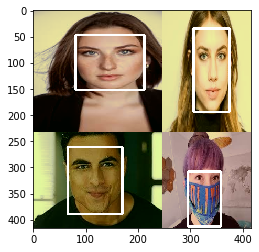

In [7]:
configuration = dict(mutations=['mosaic','horizontal_flip', 'hsv'], 
                     number_augmentations = 10,
                     mosaic_probability=1,
                     coord_type='yolo', 
                     h_flip_probability=1, 
                     hsv_probability=1,
                     hsv_hue=list(range(-25,25)), 
                     hsv_saturation=list(range(-25,25)), 
                     hsv_brightness=list(range(-25,25)),
                     save_augmentations=False)
aug = AugmentObjectDetectionData(load_path='/data/notebooks/Face_Mask_Detection/training_images/', 
                                 save_path='/data/notebooks/Face_Mask_Detection/training_images_augmented/')
aug.set_configuration(configuration=configuration)
image_paths = aug.image_paths
print('Number of Images: {}\n'.format(len(image_paths)))
print('The first 4 paths are:')
print("\n".join(image_paths[0:4]))
img, objs, bboxes = aug.mutate(image_paths[0])
print('\nExample of Image Augmentation:')
plt.imshow(cv2.cvtColor(aug.draw_boxes(img, objs, bboxes), cv2.COLOR_BGR2RGB))

In this example I create 20 augmentations per image with some randomness.<br>
Feel free to change the configuration parameters.

In [9]:
configuration = dict(mutations=['mosaic','horizontal_flip', 'hsv'], 
                     number_augmentations = 20,
                     mosaic_probability=0.25,
                     coord_type='yolo', 
                     h_flip_probability=0.5, 
                     hsv_probability=0.25,
                     hsv_hue=list(range(-25,25)), 
                     hsv_saturation=list(range(-25,25)), 
                     hsv_brightness=list(range(-25,25)),
                     save_augmentations=True)
aug = AugmentObjectDetectionData(load_path='/data/notebooks/Face_Mask_Detection/training_images/', 
                                 save_path='/data/notebooks/Face_Mask_Detection/training_images_augmented/')
aug.set_configuration(configuration=configuration)
image_paths = aug.image_paths
print('Number of Images: {}\n'.format(len(image_paths)))
for img in image_paths:
    aug.mutate(img)
print('Number of augmented training images: {}'.format(len(aug.get_imagepaths(aug.save_path))))

Number of Images: 449

Number of augmented training images: 8980


### Load the transformed Images into SAS Viya
You can now load the images into SAS Viya to check whether everything worked as expected.

In [10]:
# SAS specific imports
from swat import *
from dlpy import *
from dlpy.utils import *

In [11]:
# Connect to SAS Viya
s = CAS('localhost', 5570, 'sas', 'saspw')

In [12]:
path = '/data/notebooks/Face_Mask_Detection/training_images_augmented/'

In [13]:
# Load images into an image table
object_detection_targets = create_object_detection_table_no_xml(s, 
                                                                data_path= path,
                                                                annotation_path = path,
                                                                coord_type = 'yolo', 
                                                                output = 'detTbl')

NOTE: Images are loaded.
NOTE: Images are processed.
labels are being processed
NOTE: Object detection table is successfully created.


In [19]:
print('Number of Images: {}'.format(len(s.CASTable('detTbl'))))
s.CASTable('detTbl').head(10)

Number of Images: 8980


,idjoin,_image_,_Object0_,_Object1_,_Object2_,_Object3_,_Object4_,_Object5_,_Object6_,_Object7_,...,_Object12_height,_Object13_height,_Object14_height,_Object15_height,_Object16_height,_Object17_height,_Object18_height,_Object19_height,_Object20_height,_nObjects_
0,nomask_54_0_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,no_mask,,,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,mask_83_13_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,mask,,,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,mask_202_10_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,mask,,,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,mask_240_17_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,mask,,,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,nomask_41_9_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,no_mask,,,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5,nomask_103_8_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,no_mask,,,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
6,mask_138_9_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,mask,mask,,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
7,nomask_85_12_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,no_mask,no_mask,,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
8,nomask_116_8_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,no_mask,,,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
9,mask_44_17_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,mask,,,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


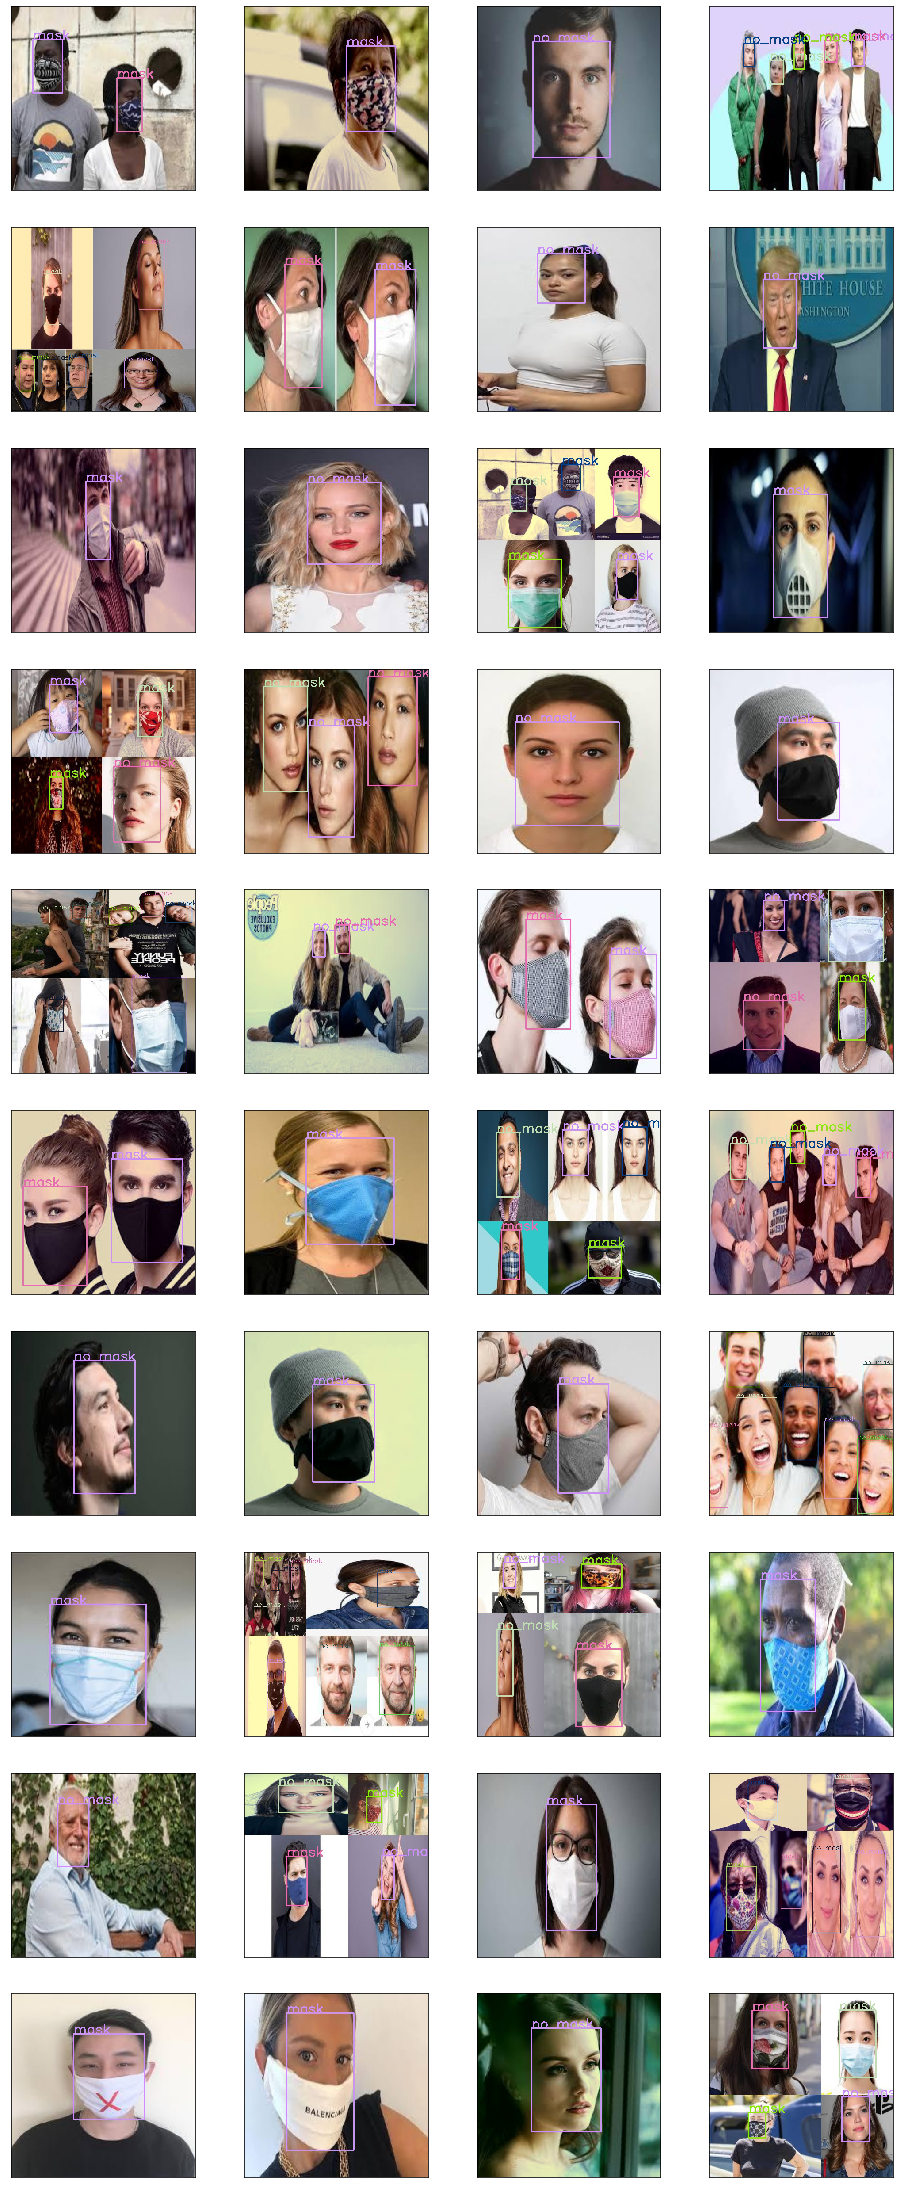

In [20]:
# Display images from image table
display_object_detections(conn=s, 
                          table='detTbl', 
                          coord_type='yolo', 
                          max_objects=10, 
                          num_plot=40, 
                          n_col=4)